In [122]:
import pandas as pd
import numpy as np
import arch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16,8)
%matplotlib inline
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

In [70]:
# Функция для визуального сравнения раельных значений с предсказанными
def visualize(df1, df2, label):
    with plt.style.context('bmh'):
        plt.plot(df1, color='blue',label='original')
        plt.plot(df2, color='red', linewidth='2', label=label)
        plt.legend()

In [106]:
# Проверка ряда на стационарность через тест Дики-Фуллера
def get_diki_fuller_stats(ts):
    stats = adfuller(ts)
    print('ADF Statistic: %f' % stats[0])
    print('p-value: %f' % stats[1])
    print('Lags Used: %f' % stats[2])
    print('Critical Values:')
    for key, value in stats[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n') 

In [123]:
# Вывод графиков исторических данных, а также автокорелляции и частной автокорелляции
def tsplot(y, title, lags=None, style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original ' + title)
    
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

In [71]:
df = pd.read_csv('monthly-boston-armed-robberies-j.csv')

In [72]:
ts = df['Count']

In [73]:
ts = np.diff(ts, n=1)

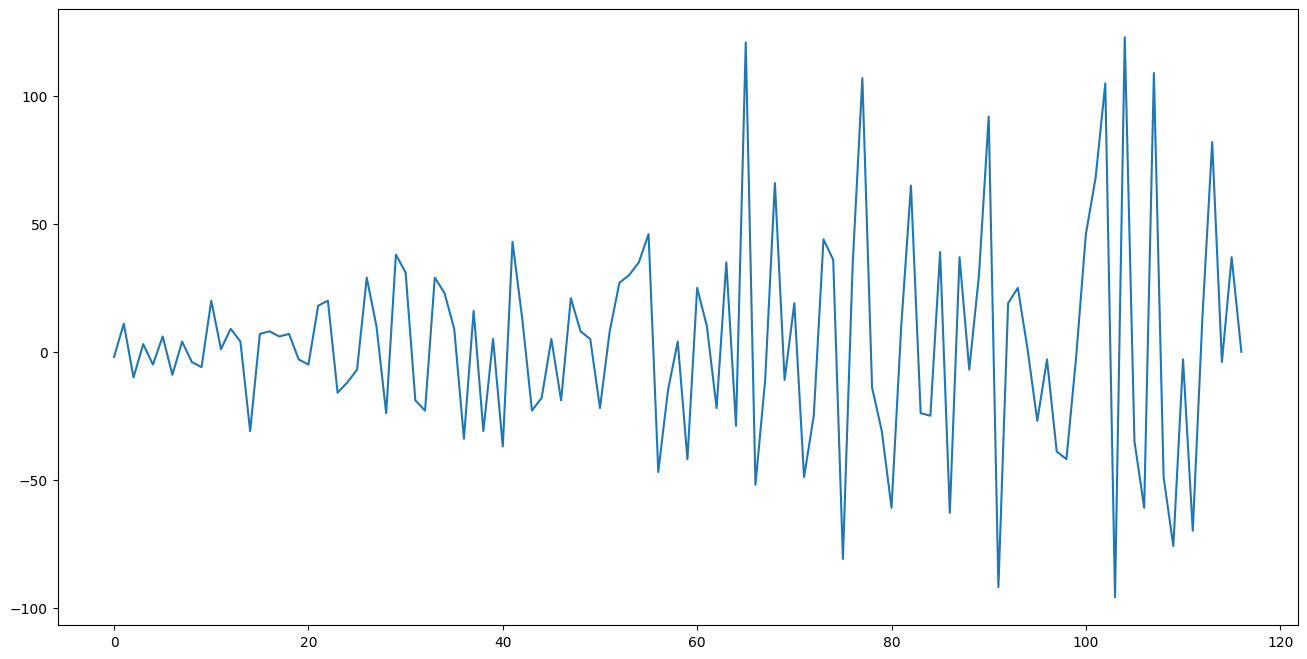

In [74]:
plt.plot(ts)

In [120]:
get_diki_fuller_stats(ts)

ADF Statistic: -7.428564
p-value: 0.000000
Lags Used: 10.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582




Тест дики-фуллера показал, что ряд стационарный

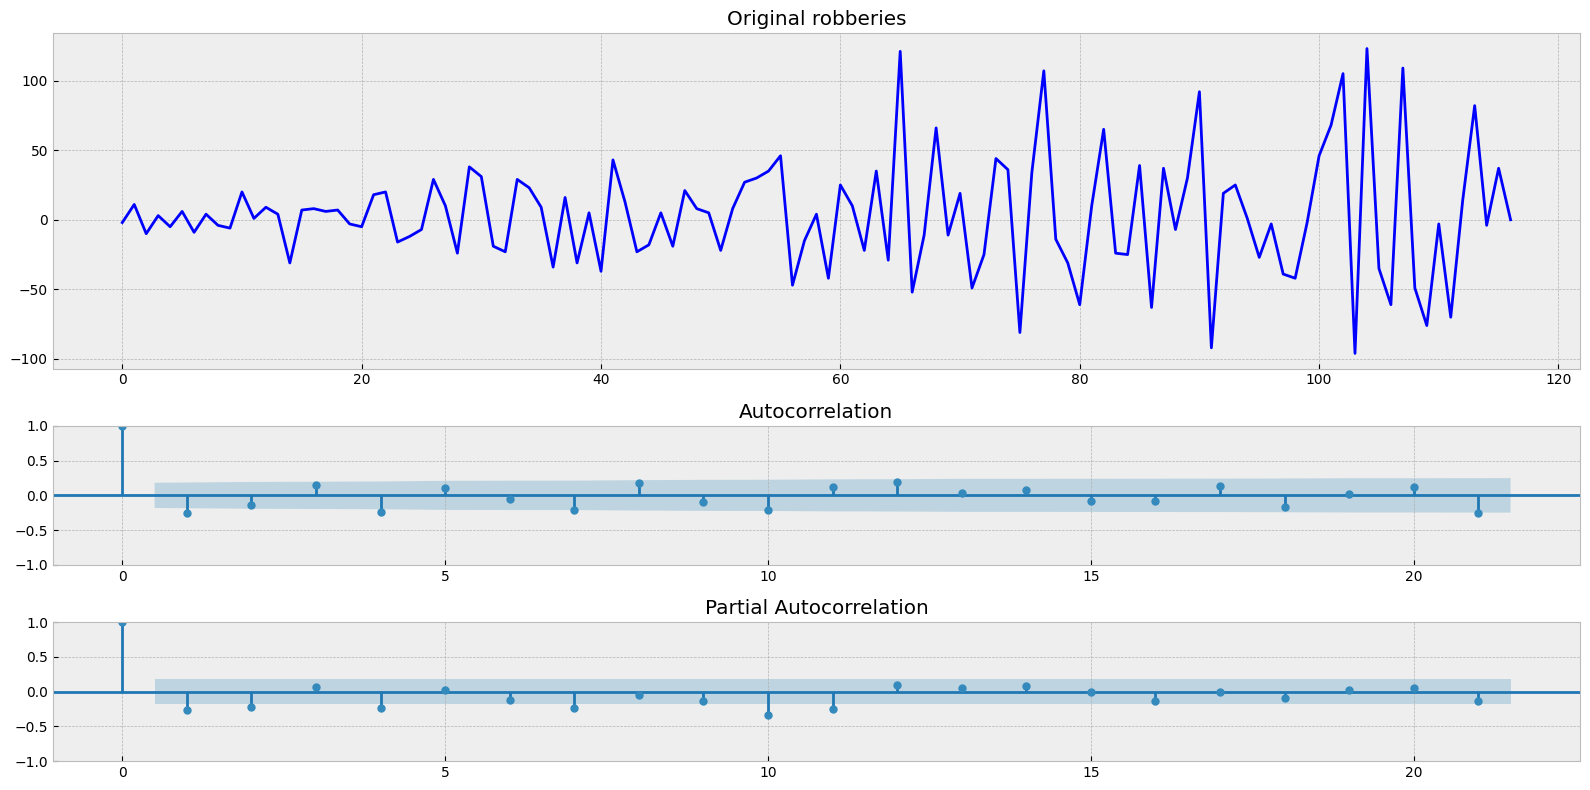

In [124]:
tsplot(ts, 'robberies')

В коррелограмме некоторые знаечния слегка выходят за доверительный интервал

В качестве значений гиперпараметров p q решено взять 2 и 2, так как p + q <= 4 для модели ARIMA (просто рекомендация, что брать окна больших размеров как такового смысла не имеет), для модели GARCH значение из модели ARIMA также подходят.

In [125]:
garch = arch.arch_model(ts, p=2, q=2)

In [126]:
fitted = garch.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 787.4344851949008
Iteration:      2,   Func. Count:     16,   Neg. LLF: 576.6350206708258
Iteration:      3,   Func. Count:     24,   Neg. LLF: 575.5882012409378
Iteration:      4,   Func. Count:     31,   Neg. LLF: 575.5846614194056
Iteration:      5,   Func. Count:     39,   Neg. LLF: 575.4929557992353
Iteration:      6,   Func. Count:     46,   Neg. LLF: 575.455054725336
Iteration:      7,   Func. Count:     53,   Neg. LLF: 575.4438770109151
Iteration:      8,   Func. Count:     60,   Neg. LLF: 575.4431793823074
Iteration:      9,   Func. Count:     67,   Neg. LLF: 575.4391883447812
Iteration:     10,   Func. Count:     74,   Neg. LLF: 575.4316490753895
Iteration:     11,   Func. Count:     81,   Neg. LLF: 575.4116254779907
Iteration:     12,   Func. Count:     88,   Neg. LLF: 575.3769096380806
Iteration:     13,   Func. Count:     95,   Neg. LLF: 575.3379087492109
Iteration:     14,   Func. Count:    102,   Neg. LLF: 575.3011461

In [127]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -575.292
Distribution:                  Normal   AIC:                           1162.58
Method:            Maximum Likelihood   BIC:                           1179.16
                                        No. Observations:                  117
Date:                Mon, Jun 12 2023   Df Residuals:                      116
Time:                        16:36:57   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2.1655      2.151      1.007      0.314 [ -2.050,  6.381]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         22.9084     21.816      1.050      0.294 [-19.850, 65.667]
alpha[1]       0.1510      0.233      0.648      0.517 [ -0.306,  0.608]
alpha[2]       0.0000      0.258      0.000      1.000 [ -0.506,  0.506]
beta[1]        0.5489      1.073      0.512      0.609 [ -1.554,  2.652]
beta[2]        0.3001      1.044      0.288      0.774 [ -1.745,  2.346]
========================================================================

Covariance estimator: robust
"""

In [128]:
garch_forecast = fitted.forecast(horizon=100, reindex=True)

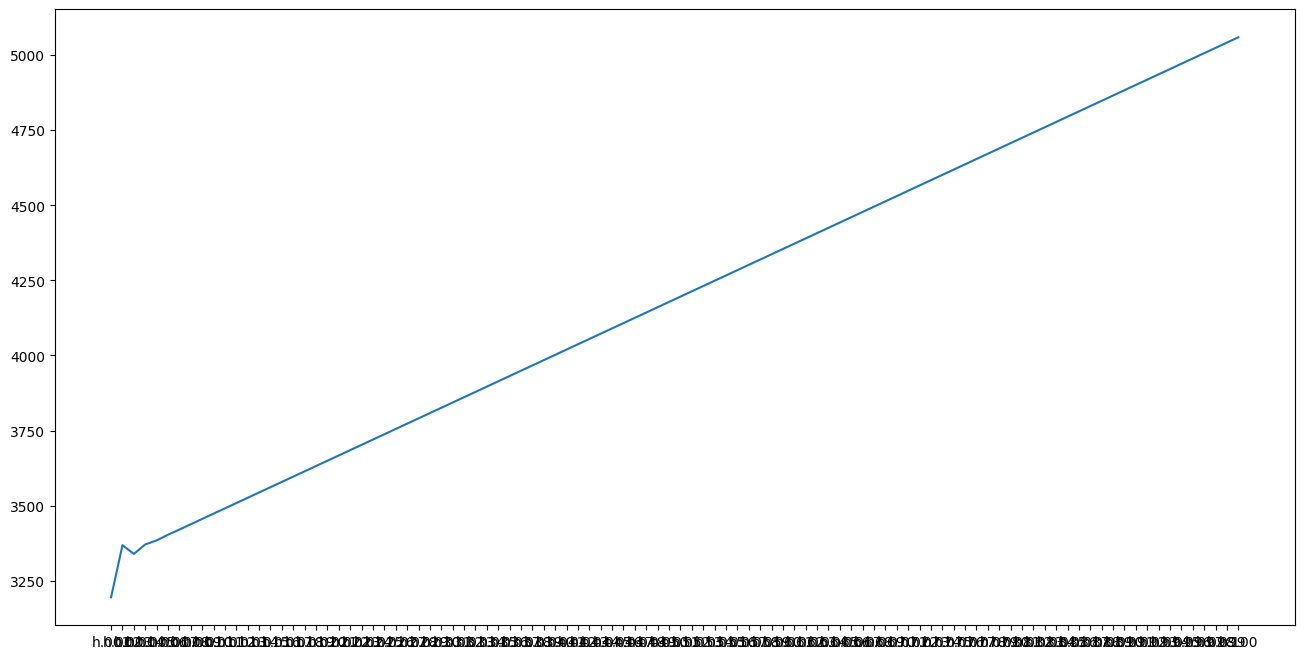

In [129]:
plt.plot(garch_forecast.residual_variance.iloc[-1])

В принципе график дисперсии полученный через garch, очень похож на реальную дисперсию ряда. В начале разброс данных был слабым, но со временем он продолжал увеличиваться, что говорит о росте дисперсии, также это  отражено на графике.  